In this notebook, we replicate the simulations by Esfahani and Kuhn (2015). The evaluation appears in section 7.

## Prerequisites

You need a license to use the MOSEK solver via Fusion API.

## Python Dependencies

In [3]:
import numpy as np
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mosek.fusion import *
from tqdm import tqdm
import sys
from scipy.stats import norm
from sklearn.model_selection import train_test_split

## Restart Simulations? If so, how many?

If you want to redo the simulations, then change the below variable to True.

In [4]:
runExperimentFig5 = True
runExperimentFig6 = True

In addition, we can control the number of simulations and the granularity.

In [5]:
nSim = 200
epsGrid = 40
epsUpper = 0
epsLower = -4
epsCollection=10**np.linspace(epsLower,epsUpper, epsGrid)

## Experiment Settings

We start by specifying the parameters.

In [6]:
# Number of assets
m = 10 

# Systematic risk factors
muSystematic = 0
varSystematic = 0.02**2

# Idiosyncratic risk factors
muIdiosyncratic = 0.03
varIdiosyncratic = 0.025**2

# Parameters
beta = 1 - 0.20
rho = 10

Then we define a function to simulate returns. First we define the moments.

In [7]:
muSim = muIdiosyncratic*np.arange(1,m+1)
sigmaSim = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        if i != j:
            sigmaSim[i,j] = varSystematic
        else:
            sigmaSim[i,j] = varSystematic + ((i+1)**2)*varIdiosyncratic

Compare with dummy simulation.

In [74]:
def simulateReturns(m, N):
    return np.random.multivariate_normal(muSim, sigmaSim, size=N)

## Implementation of CVaR Minimization

Before we dive into solving the DRO model, we start by investigating CVaR.

In [76]:
class CVaR:

    def __init__(self, returnsAssets=None, beta=0.80):

        # --------- Static variables ---------
        self.beta = beta;
        self.N, self.M = returnsAssets.shape;
        self.returnsAssets = returnsAssets;
        self.results = None;

    # Method 3: Run model
    def solve(self):

        # --------- Instantiate model ---------
        MODEL = Model("CVaR");
        
        # --------- Fixed Parameters ---------
        N = self.N
        M = self.M
        beta = self.beta
        returns = self.returnsAssets

        # --------- Decision Variables ---------
        w = MODEL.variable("w", M, Domain.greaterThan(0.0)) # -> Weights in each asset
        nu = MODEL.variable("nu");                          # -> VaR in optimization problem
        t = MODEL.variable("t", N);                         # -> Maximum operator in optimization problem
    
        # Define a loss function
        lossFunction = Expr.neg(Expr.mul(returns, w))
    
        # --------- Portfolio Constraints (w \in W) ---------
        CW1 = MODEL.constraint('budgetConstraint', Expr.sum(w), Domain.equalsTo(1.0));
        
        # --------- Maximum Operator ---------
        CW2 = MODEL.constraint('Maximum1', t, Domain.greaterThan(0.0));
        CW3 = MODEL.constraint('Maximum2', Expr.sub(Expr.sub(lossFunction, Expr.repeat(nu, N, 0)), t), Domain.lessThan(0.0));

        # --------- Objective (Certificate) ---------
        J = Expr.add(nu, Expr.mul((1/(N*(1-beta))), Expr.sum(t)));
        MODEL.objective('obj', ObjectiveSense.Minimize, J);

        # Record original objective
        recordedValues = ["CVaR-{}".format(int(beta*100)), "VaR-{}".format(int(beta*100))];
        columns = recordedValues + [i for i in range(1,M+1)];
        results = pd.DataFrame(columns=columns)
        
        # Use Simplex instead of Interior Point 
        MODEL.setSolverParam('optimizer', 'freeSimplex')

        # Solve model
        MODEL.solve();

        # Get problem status
        statusPrimal = MODEL.getPrimalSolutionStatus();
        statusDual = MODEL.getDualSolutionStatus();

        # Check for optimality
        if statusPrimal == SolutionStatus.Optimal and statusDual == SolutionStatus.Optimal:

            # Save row
            row = pd.DataFrame([MODEL.primalObjValue(), nu.level()[0]] + list(w.level()), index=columns, columns=[0]);

            # Concatenate with exisiting results
            results = pd.concat([results, row.T], axis=0);

        else:
            print("Primal status: {}".format(statusPrimal), "Dual status: {}".format(statusDual))
                
        # Set index
        results.index = [i for i in range(0, len(results))];

        # Return all results
        return results;

Then we test it on 10 assets and 200 simulations.

In [77]:
testReturns = simulateReturns(m, 10000)
MODEL = CVaR(returnsAssets=testReturns, beta=beta)
results = MODEL.solve()
wTest = results.iloc[:,2:].values[0]
print((results['VaR-{}'.format(int(beta*100))].values[0], results['CVaR-{}'.format(int(beta*100))].values[0]))

(-0.15396503735063063, -0.10953343312898378)


Then we can try to calculate VaR and CVaR analytically as we know the optimal portfolio.

In [78]:
def AnalyticalRisks(w, mu=muSim, Sigma=sigmaSim, beta=beta):
    
    # Define portfolio moments
    muPortfolio = muSim@w                     
    varPortfolio = w.T@Sigma@w
    sigmaPortfolio = np.sqrt(varPortfolio)
    
    # Define CVaR
    VaR = -muPortfolio + sigmaPortfolio*norm.ppf(beta)
    CVaR = -muPortfolio + sigmaPortfolio*norm.pdf(norm.ppf(beta))/(1 - beta)      
    return muPortfolio, VaR, CVaR 

# Compute out-of-sample performance for each portfolio in each simulation
print(AnalyticalRisks(wTest, beta=beta))

(0.2227055936730653, -0.15598609247627082, -0.11173572421998318)


We can test whether this is correctly implemented. We take the optimal portfolio, calculate the portfolio returns, and estimate CVaR and VaR.

In [79]:
portfolioReturns = np.array(testReturns @ wTest, dtype=np.float64)
portfolioLosses = -portfolioReturns
VaREstimate = -np.quantile(portfolioReturns, 1-beta)
CVaREstimate = VaREstimate + 1/(1-beta)*np.mean(np.maximum(portfolioLosses - VaREstimate, 0))
print((VaREstimate, CVaREstimate))

(-0.15396503735063066, -0.10953343312898386)


## Implementation of SAA and DRO

Then we specify the model and solve it.

In [80]:
class ECvaRDRO:

    # Constructor: Create static variables
    def __init__(self, returnsAssets=None, beta=0.80, rho=10):

        # --------- Static variables ---------
        self.beta = beta;
        self.rho = rho;
        self.N, self.M = returnsAssets.shape;
        self.returnsAssets = returnsAssets;
        self.optimalPortfolios = None;
        self.isOptimal = False;
        self.results = None;

    # Method 3: Run model
    def solve(self, epsCollection=np.linspace(10**(-8), 10**(-1), 100), progressBar=True):

        # --------- Instantiate model ---------
        MODEL = Model("DRO");
        
        # --------- Fixed Parameters ---------
        N = self.N
        M = self.M
        rho = self.rho
        beta = self.beta

        # --------- Variable Parameters ---------
        eps = MODEL.parameter("WassersteinRadius"); # -> radius with respect to 1-norm

        # --------- Decision Variables ---------
        w = MODEL.variable("w", M, Domain.greaterThan(0.0)) # -> Weights in each asset
        s = MODEL.variable("s_i", N);                       # -> Maximum of affine functions
        _lambda = MODEL.variable("lambda");                 # -> Absolute value of coefficient in affine function
        nu = MODEL.variable("nu");                          # -> VaR in optimization problem

        # --------- Auxilliaries ---------
        nOnes = np.ones(N);
        mOnes = np.ones(M);

        # --------- Objective (Certificate) ---------
        firstTerm = Expr.mul(eps, _lambda);
        secondTerm = Expr.mul(1/N, Expr.sum(s));
        J = Expr.add(firstTerm, secondTerm);
        MODEL.objective('obj', ObjectiveSense.Minimize, J);

        # --------- Portfolio Constraints (w \in W) ---------
        # No shorting appears directly from the definition of the decision variables
        CW1 = MODEL.constraint('budgetConstraint', Expr.sum(w), Domain.equalsTo(1.0));

        # --------- Affine Functions (Coefficients) ---------
        K = 2
        a_k = [-1, -1 - rho/(1 - beta)];
        b_k = [rho, rho*(1 - 1/(1 - beta))];

        # --------- Constraints on Affine Functions ---------
        for k in range(K):

            # Yields a vector of dimension N x 1
            bkVec = Expr.mul(nu, b_k[k]*nOnes); 
            # Yields a vector of dimension N x 1
            akVecInnerProduct = Expr.mul(a_k[k], Expr.mul(self.returnsAssets, w)); 
            # Create coefficients
            akVec = Expr.mul(a_k[k], w)
            
            # Add the constraints
            MODEL.constraint('maximumAffine_{}'.format(k), Expr.add([bkVec, akVecInnerProduct, Expr.neg(s)]), Domain.lessThan(0.0));
            MODEL.constraint('infinityNormReturn1_{}'.format(k), Expr.sub(akVec, Expr.mul(mOnes, _lambda)), Domain.lessThan(0.0));
            MODEL.constraint('infinityNormReturn2_{}'.format(k), Expr.sub(Expr.neg(akVec), Expr.mul(mOnes, _lambda)), Domain.lessThan(0.0));

        # Record original objective
        recordedValues = ["Objective", "WassersteinRadius", "Rho", "Beta", "Lambda", "VaR-{}".format(int(beta*100)), "CVaR-{}".format(int(beta*100))];
        columns = recordedValues + [i for i in range(1,M+1)];
        results = pd.DataFrame(columns=columns)
        
        # Use Simplex instead of Interior Point 
        MODEL.setSolverParam('optimizer', 'freeSimplex')

        # Solve optimization for each epsilon (Wasserstein radius)
        with tqdm(total=len(epsCollection), disable=not(progressBar)) as pbar:
            for epsNext in epsCollection:

                # Set parameter
                eps.setValue(epsNext);

                # Solve model
                MODEL.solve();

                # Get problem status
                statusPrimal = MODEL.getPrimalSolutionStatus();
                statusDual = MODEL.getDualSolutionStatus();
                
                # Check for optimality
                if statusPrimal == SolutionStatus.Optimal and statusDual == SolutionStatus.Optimal:
                    
                    # Calculate estimate for CVaR
                    returns = self.returnsAssets @ w.level()
                    CVaR = nu.level()[0] + (1/(1-beta))*np.mean(np.maximum(-returns-nu.level()[0], 0))
                
                    # Save row
                    row = pd.DataFrame([MODEL.primalObjValue(), eps.getValue()[0], rho, beta, _lambda.level()[0], nu.level()[0], CVaR] + list(w.level()), index=columns, columns=[0]);

                    # Concatenate with exisiting results
                    results = pd.concat([results, row.T], axis=0);
                    
                else:
                    print("WR: {}".format(eps.getValue()[0]), "Primal status: {}".format(statusPrimal), "Dual status: {}".format(statusDual))

                # Increment loading bar
                pbar.update(1);
                
        # Set index
        results.index = [i for i in range(0, len(results))];

        # Set optimal portfolio
        self.optimalPortfolios = results.values[:, len(recordedValues):];
        self.results = results;
        self.isOptimal = True;

        # Return all results
        return results;
    
    # Compute out-of-sample performance
    def SampleAverage(self, w, validationReturns, beta=0.80, rho=10):
        
        portfolioLosses = -validationReturns@w
        VaREstimate = np.quantile(portfolioLosses, beta)
        CVaREstimate = VaREstimate + 1/(1-beta)*np.mean(np.maximum(portfolioLosses - VaREstimate, 0))
        lossEstimate = np.mean(portfolioLosses)
        J = lossEstimate + rho*CVaREstimate 
        #print(VaREstimate, CVaREstimate)
        return J
        
class ECvaRSAA:

    # Constructor: Create static variables
    def __init__(self, returnsAssets=None, beta=0.80, rho=10):

        # --------- Static variables ---------
        self.beta = beta;
        self.rho = rho;
        self.N, self.M = returnsAssets.shape;
        self.returnsAssets = returnsAssets;
        self.optimalPortfolios = None;
        self.isOptimal = False;
        self.results = None;

    # Method 3: Run model
    def solve(self, epsCollection=np.linspace(10**(-8), 10**(-1), 100), progressBar=True):

        MODEL = Model("SAA");

        # Get dimensions
        N = self.N    # -> Number of scenarios
        M = self.M;   # -> Number of available assets to invest in

        # Get parameters
        beta = self.beta;

        # Decision variable (fraction of holdings in each security)
        w = MODEL.variable("w", M, Domain.greaterThan(0.0))
        nu = MODEL.variable("nu", Domain.unbounded())
        u = MODEL.variable("u", N, Domain.greaterThan(0.0))

        # Auxiliaries
        eCVaR = np.ones((N, 1));
        eBudget = np.ones((M, 1));

        # Objective
        expectedLoss = Expr.neg(Expr.mul(1/N, Expr.sum(Expr.mul(self.returnsAssets, w))))
        expectedCVaR = Expr.add(nu, Expr.mul(1/(N*(1 - beta)), Expr.sum(u)));
        MODEL.objective('obj', ObjectiveSense.Minimize, Expr.add(expectedLoss, Expr.mul(rho, expectedCVaR)));

        # Budget constraint
        MODEL.constraint('budgetConstraint', Expr.dot(eBudget, w), Domain.equalsTo(1))

        # CVaR constraint
        MODEL.constraint('CVaRConstraint', Expr.add(Expr.mul(self.returnsAssets, w), Expr.add(Expr.mul(nu, eCVaR), u)), Domain.greaterThan(0.0))

        recordedValues = ["obj", "rho", "beta", "VaR-{}".format(beta)];
        columns = recordedValues + [i for i in range(1,M+1)];
        results = pd.DataFrame(columns=columns)

        # Solve optimization.
        MODEL.solve();

        # Get problem status.
        prosta = MODEL.getProblemStatus();

        # If model is not infeasible, then record the solution.
        if prosta != ProblemStatus.PrimalInfeasible:

            # Save row
            row = pd.DataFrame([MODEL.primalObjValue(), rho, beta, nu.level()[0]] + list(w.level()), index=columns, columns=[0]);

            # Concatenate with exisiting results
            results = pd.concat([results, row.T], axis=0);

        # Set optimal portfolio
        self.optimalPortfolio = results.iloc[0, :];
        self.optimalPortfolio = self.optimalPortfolio.values[len(recordedValues):];
        self.isOptimal = True;

        return results;
    
    # Compute out-of-sample performance
    def SampleAverage(self, validationReturns, beta=0.80, rho=10):
        
        w = self.optimalPortfolio
        portfolioLosses = -validationReturns@w
        VaREstimate = np.quantile(portfolioLosses, beta)
        CVaREstimate = VaREstimate + 1/(1-beta)*np.mean(np.maximum(portfolioLosses - VaREstimate, 0))
        lossEstimate = np.mean(portfolioLosses)
        J = lossEstimate + rho*CVaREstimate 
        return J
        

## Results

### Fig. 4 (page 154)

Then define the number of simulations and the granularity of the Wasserstein grid are specified in the beginning of the notebook.

The first step is to simulate the data, and then we specify the Wasserstein radii range. Lastly, we solve the model. This is repeated to obtain an average of the portfolio weights. The simulation takes approximately 10 minutes for 200 simulations.

In [81]:
if runExperimentFig5:
    
    # Set weights to zero
    totalT1 = np.zeros((nSim, epsGrid, m+7))
    totalT2 = np.zeros((nSim, epsGrid, m+7))
    totalT3 = np.zeros((nSim, epsGrid, m+7))

    # Simulate data in a loop and compute average weights
    with tqdm(total=nSim) as pbar:

        # Loop over experiments
        for i in range(nSim):

            # Simulate data
            T1 = simulateReturns(m, 30)
            T2 = simulateReturns(m, 300)
            T3 = simulateReturns(m, 3000)

            # Specify Wasserstein radii range
            epsCollectionNew = 10**np.linspace(epsLower,epsUpper,epsGrid)

            # Results for N = 30
            model = ECvaRDRO(returnsAssets=T1, beta=beta, rho=rho)
            resultsT1 = model.solve(epsCollection=epsCollection, progressBar=False)
            totalT1[i,:,:] = np.array(resultsT1.values, dtype=np.float64)

            # Results for N = 300
            model = ECvaRDRO(returnsAssets=T2, beta=beta, rho=rho)
            resultsT2 = model.solve(epsCollection=epsCollection, progressBar=False)
            totalT2[i,:,:] = np.array(resultsT2.values, dtype=np.float64)

            # Results for N = 3000
            model = ECvaRDRO(returnsAssets=T3, beta=beta, rho=rho)
            resultsT3 = model.solve(epsCollection=epsCollection, progressBar=False)
            totalT3[i,:,:] = np.array(resultsT3.values, dtype=np.float64)

            # Update loadbar
            pbar.update(1)
            
    # Save the data
    np.savetxt('./ReplicationResults/N30_{}_{}_{}.txt'.format(nSim, epsGrid, m+7), totalT1.flatten(), fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/N300_{}_{}_{}.txt'.format(nSim, epsGrid, m+7), totalT2.flatten(), fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/N3000_{}_{}_{}.txt'.format(nSim, epsGrid, m+7), totalT3.flatten(), fmt='%.18e', delimiter=' ')
    
    # Then specify the weights
    wT1 = totalT1[:,:,7:]
    wT2 = totalT2[:,:,7:]
    wT3 = totalT3[:,:,7:]

else:
    
    # Load the data
    totalT1 = np.loadtxt('./ReplicationResults/N30_{}_{}_{}.txt'.format(nSim, epsGrid, m+7), delimiter=' ').reshape(nSim,epsGrid,m+7)
    totalT2 = np.loadtxt('./ReplicationResults/N300_{}_{}_{}.txt'.format(nSim, epsGrid, m+7), delimiter=' ').reshape(nSim,epsGrid,m+7)
    totalT3 = np.loadtxt('./ReplicationResults/N3000_{}_{}_{}.txt'.format(nSim, epsGrid, m+7), delimiter=' ').reshape(nSim,epsGrid,m+7)
    
    # Then specify the weights
    wT1 = totalT1[:,:,7:]
    wT2 = totalT2[:,:,7:]
    wT3 = totalT3[:,:,7:]   

100%|█████████████████████████████████████████| 200/200 [04:44<00:00,  1.42s/it]


Compute the average weights.

In [82]:
Avg_wT1 = np.mean(wT1, axis=0)
Avg_wT2 = np.mean(wT2, axis=0)
Avg_wT3 = np.mean(wT3, axis=0)

Then we try to calculate the result analytically.

In [83]:
print(AnalyticalRisks(totalT3[-1,0,7:], beta=beta))

(0.2364949203737615, -0.1612175214129245, -0.11129129945920635)


Then we approximate it from the samples.

In [84]:
T3 = simulateReturns(m, 3000)
portfolioReturns = np.array(T3 @ np.array(totalT3[-1,0,7:], dtype=np.float64), dtype=np.float64)
portfolioLosses = -portfolioReturns
VaREstimate = -np.quantile(portfolioReturns, 1-beta)
CVaREstimate = VaREstimate + 1/(1-beta)*np.mean(np.maximum(portfolioLosses - VaREstimate, 0))
print((VaREstimate, CVaREstimate))

(-0.15977053907137295, -0.10941188444813105)


It seems like they agree to a satisfactory degree.

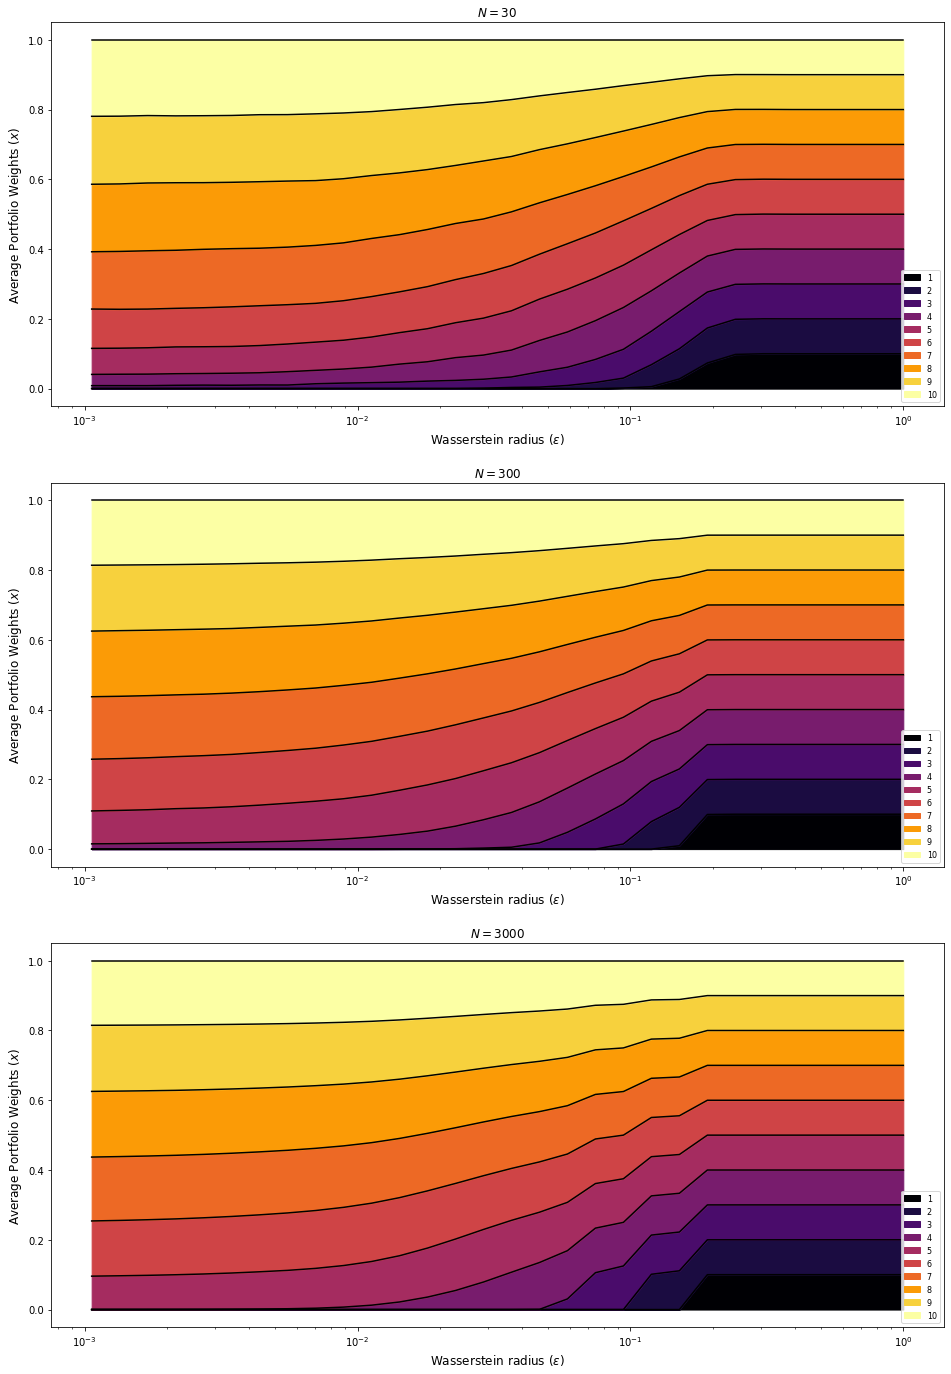

In [85]:
# Compute start index to match plot in paper
startIndex = epsGrid//(epsUpper-epsLower)

# N = 30
wCumSumT1 = np.cumsum(Avg_wT1[startIndex:,:], axis=1)

# N = 300
wCumSumT2 = np.cumsum(Avg_wT2[startIndex:,:], axis=1)

# N = 3000
wCumSumT3 = np.cumsum(Avg_wT3[startIndex:,:], axis=1)

# Get asset names
assetNames = np.array([i for i in range(1,m+1)], dtype=str)

# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,m))

# Plot the weights
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 24))

# Start with N = 30
ax[0].plot(epsCollection[startIndex:], wCumSumT1, color='black')
ax[0].fill_between(epsCollection[startIndex:], wCumSumT1[:,0], color=colors[0,:], label=assetNames[0])
for i in range(1,10):
    ax[0].fill_between(epsCollection[startIndex:], wCumSumT1[:,i-1], wCumSumT1[:,i], color=colors[i,:], label=assetNames[i])
ax[0].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[0].set_ylabel(r'Average Portfolio Weights ($x$)', fontsize=12)
ax[0].legend(loc="lower right", facecolor="white", fontsize=8)
ax[0].set_xscale('log')
ax[0].set_title(r'$N = 30$')

# ..then N = 300
ax[1].plot(epsCollection[startIndex:], wCumSumT2, color='black')
ax[1].fill_between(epsCollection[startIndex:], wCumSumT2[:,0], color=colors[0,:], label=assetNames[0])
for i in range(1,10):
    ax[1].fill_between(epsCollection[startIndex:], wCumSumT2[:,i-1], wCumSumT2[:,i], color=colors[i,:], label=assetNames[i])
ax[1].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[1].set_ylabel(r'Average Portfolio Weights ($x$)', fontsize=12)
ax[1].legend(loc="lower right", facecolor="white", fontsize=8)
ax[1].set_xscale('log')
ax[1].set_title(r'$N = 300$')

# ..finally N = 3000
ax[2].plot(epsCollection[startIndex:], wCumSumT3, color='black')
ax[2].fill_between(epsCollection[startIndex:], wCumSumT3[:,0], color=colors[0,:], label=assetNames[0])
for i in range(1,10):
    ax[2].fill_between(epsCollection[startIndex:], wCumSumT3[:,i-1], wCumSumT3[:,i], color=colors[i,:], label=assetNames[i])
ax[2].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[2].set_ylabel(r'Average Portfolio Weights ($x$)', fontsize=12)
ax[2].legend(loc="lower right", facecolor="white", fontsize=8)
ax[2].set_xscale('log')
ax[2].set_title(r'$N = 3000$')

# Save figure
plt.savefig('./ReplicationResults/Fig4_{}_{}_{}.png'.format(nSim, epsGrid, m+7), dpi=200)

# Show figure
plt.show()

There appear to be a minor descrepancy between the paper and this illustration. I suspect it stems from a different choice of simulation parameters, which appear to be different from the stated in the article.

### Fig. 5 (page 155)

Now that we have the optimal weights for the portfolio as a function of the Wasserstein radius $\epsilon$, we can recreate Fig. 5. We need to compute the out-of-sample performance under 200 simulations. We start by defining the analytical out-of-sample performance function.

In [87]:
def OoSPerformance(w, mu=muSim, Sigma=sigmaSim, beta=beta, rho=10):  
    muPortfolio, VaRPortfolio, CVaRPortfolio = AnalyticalRisks(w.T, mu=mu, Sigma=Sigma, beta=beta)  
    return -muPortfolio + rho*CVaRPortfolio

Then we calculate the performance for the portfolios we got from the simulation earlier.

In [88]:
OoSResultsT1 = np.zeros((nSim, epsGrid))
for i in range(nSim):
    for j in range(epsGrid):
        OoSResultsT1[i,j] = OoSPerformance(totalT1[i,j,7:]) 

OoSResultsT2 = np.zeros((nSim, epsGrid))
for i in range(nSim):
    for j in range(epsGrid):
        OoSResultsT2[i,j] = OoSPerformance(totalT2[i,j,7:])  

OoSResultsT3 = np.zeros((nSim, epsGrid))
for i in range(nSim):
    for j in range(epsGrid):
        OoSResultsT3[i,j] = OoSPerformance(totalT3[i,j,7:])       

Then we calculate the reliability.

In [89]:
ReliabilityN30 = (np.sum(OoSResultsT1 < totalT1[:,:,0], axis=0)/nSim)*100
ReliabilityN300 = (np.sum(OoSResultsT2 < totalT2[:,:,0], axis=0)/nSim)*100
ReliabilityN3000 = (np.sum(OoSResultsT3 < totalT3[:,:,0], axis=0)/nSim)*100

Then we can make the plot.

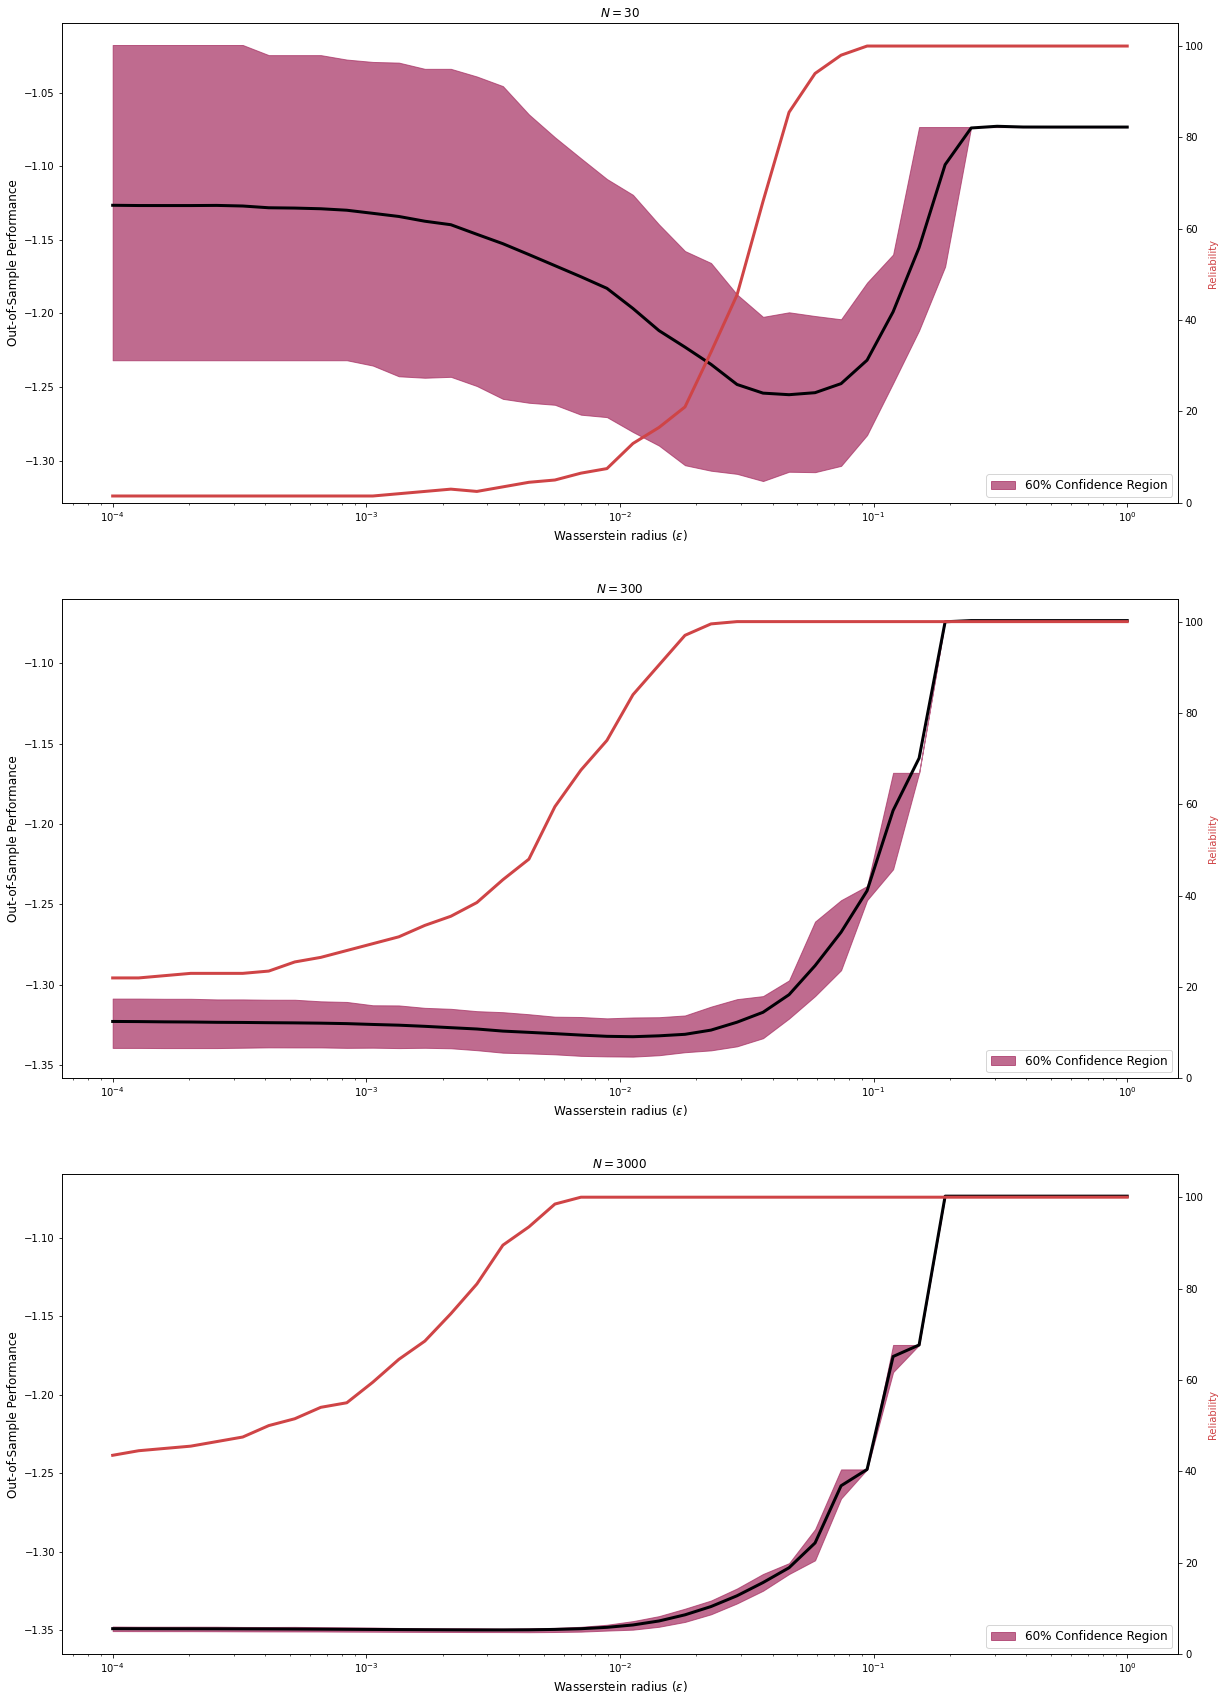

In [90]:
# Set colors from the scale used for plotting the weights
colorLine = colors[0]
colorCI = colors[4]
colorReliability = colors[5]

# Control the width of the confidence intervals
lower = 0.20
upper = 0.80

# Plot the OoS-performance
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))

# Start with N = 30
ax[0].plot(epsCollection, np.mean(OoSResultsT1, axis=0), color=colorLine, linewidth=3)
ax[0].fill_between(epsCollection, np.quantile(OoSResultsT1, lower, axis=0), np.quantile(OoSResultsT1, upper, axis=0), color=colorCI, alpha=0.7, label="{}% Confidence Region".format(int(100*(upper-lower))))
ax[0].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[0].set_ylabel(r'Out-of-Sample Performance', fontsize=12)
ax[0].legend(loc="lower right", facecolor="white", fontsize=12)
ax[0].set_xscale('log')
ax[0].set_title(r'$N = 30$')
ax0 = ax[0].twinx()
ax0.set_ylabel('Reliability', color=colorReliability)
ax0.plot(epsCollection, ReliabilityN30, color=colorReliability, linewidth=3)
ax0.set_yticks(np.arange(0, 120, 20))
ax0.set_ylim(0, 105)

# ..then N = 300
ax[1].plot(epsCollection, np.mean(OoSResultsT2, axis=0), color=colorLine, linewidth=3)
ax[1].fill_between(epsCollection, np.quantile(OoSResultsT2, lower, axis=0), np.quantile(OoSResultsT2, upper, axis=0), color=colorCI, alpha=0.7, label="{}% Confidence Region".format(int(100*(upper-lower))))
ax[1].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[1].set_ylabel(r'Out-of-Sample Performance', fontsize=12)
ax[1].legend(loc="lower right", facecolor="white", fontsize=12)
ax[1].set_xscale('log')
ax[1].set_title(r'$N = 300$')
ax1 = ax[1].twinx()
ax1.set_ylabel('Reliability', color=colorReliability)
ax1.plot(epsCollection, ReliabilityN300, color=colorReliability, linewidth=3)
ax1.set_yticks(np.arange(0, 120, 20))
ax1.set_ylim(0, 105)

# ..finally N = 3000
ax[2].plot(epsCollection, np.mean(OoSResultsT3, axis=0), color=colorLine, linewidth=3)
ax[2].fill_between(epsCollection, np.quantile(OoSResultsT3, lower, axis=0), np.quantile(OoSResultsT3, upper, axis=0), color=colorCI, alpha=0.7, label="{}% Confidence Region".format(int(100*(upper-lower))))
ax[2].set_xlabel(r'Wasserstein radius ($\epsilon$)', fontsize=12)
ax[2].set_ylabel(r'Out-of-Sample Performance', fontsize=12)
ax[2].legend(loc="lower right", facecolor="white", fontsize=12)
ax[2].set_xscale('log')
ax[2].set_title(r'$N = 3000$')
ax2 = ax[2].twinx()
ax2.set_ylabel('Reliability', color=colorReliability)
ax2.plot(epsCollection, ReliabilityN3000, color=colorReliability, linewidth=3)
ax2.set_yticks(np.arange(0, 120, 20))
ax2.set_ylim(0, 105)

# Save figure
plt.savefig('./ReplicationResults/Fig5_{}_{}_{}.png'.format(nSim, epsGrid, m+7), dpi=200)

# Show figure
plt.show()

### Portfolios driven by out-of-sample performance: Fig. 6 (page 157)

We start by using the hold-out method. This means we reserve approximately 20% of the dataset for testing.

In [91]:
# Size of validation set
validationSize = 0.20

# Control epsilon grid
epsCollection = np.array([(b * 10**c) for b in range(10) for c in [-3, -2, -1]])

# Specify number of simulations
nSim = 200

# Specify grid
gridN = np.arange(10, 1010, 50)

# Allocate memory for OoS results
results_DRO_OoS_SA_Fig6 = np.zeros((nSim, len(gridN)))
results_DRO_OoS_epsOpt_Fig6 = np.zeros((nSim, len(gridN)))
results_SAA_OoS_Fig6 = np.zeros((nSim, len(gridN)))

# Allocate memory for certificate results
results_DRO_SA_Certificate_Fig6 = np.zeros((nSim, len(gridN)))
results_DRO_epsOpt_Certificate_Fig6 = np.zeros((nSim, len(gridN)))
results_SAA_Certificate_Fig6 = np.zeros((nSim, len(gridN)))

if runExperimentFig6:
    
    with tqdm(total=nSim) as pbar:

        # Carry out simulations
        for s in range(0,nSim):
            for i, N in enumerate(gridN):

                # Simulate returns
                simReturns = simulateReturns(m, N)
                trainReturns, testReturns = train_test_split(simReturns, test_size=validationSize)

                # Fit model
                modelDROHoldOut = ECvaRDRO(returnsAssets=trainReturns, beta=beta, rho=rho)
                modelSAAHoldOut = ECvaRSAA(returnsAssets=trainReturns, beta=beta, rho=rho)
                resultsDROHoldOut = modelDROHoldOut.solve(epsCollection=epsCollection, progressBar=False)
                resultsSAAHoldOut = modelSAAHoldOut.solve(progressBar=False)

                # Allocate memory for performance objective
                J_out_SA = np.zeros(len(epsCollection))
                J_out_Analytical = np.zeros(len(epsCollection))

                # Compute SA for all Wasserstein radii
                for j in range(resultsDROHoldOut.shape[0]):
                    w = np.array(resultsDROHoldOut.iloc[j, 7:].values, dtype=np.float64)
                    J_out_SA[j] = modelDROHoldOut.SampleAverage(w, testReturns)
                    J_out_Analytical[j] = OoSPerformance(w)

                # Select epsilon that minimizes the realized objective value
                optIndexSA = np.argmin(J_out_SA)
                optIndex = np.argmin(J_out_Analytical)
                wEpsOptSA = np.array(resultsDROHoldOut.iloc[optIndexSA, 7:].values, dtype=np.float64)
                wEpsOpt = np.array(resultsDROHoldOut.iloc[optIndex, 7:].values, dtype=np.float64)
                
                # Get portfolio from SAA
                wSAA = modelSAAHoldOut.optimalPortfolio

                # Compute theoretical out-of-sample performance
                results_DRO_OoS_SA_Fig6[s,i] = OoSPerformance(wEpsOptSA)
                results_DRO_OoS_epsOpt_Fig6[s,i] = OoSPerformance(wEpsOpt)
                results_SAA_OoS_Fig6[s,i] = OoSPerformance(wSAA)
                
                # Save certificates
                results_SAA_Certificate_Fig6[s,i] = resultsSAAHoldOut['obj'].values[0]
                results_DRO_SA_Certificate_Fig6[s,i] = resultsDROHoldOut['Objective'].values[optIndexSA]
                results_DRO_epsOpt_Certificate_Fig6[s,i] = resultsDROHoldOut['Objective'].values[optIndex]
                
                
            
            # Update bar
            pbar.update(1)
            
    # Save reliabilities
    Reliability_SAA = (np.sum(results_SAA_OoS_Fig6 < results_SAA_Certificate_Fig6, axis=0)/nSim)*100
    Reliability_DRO_SA = (np.sum(results_DRO_OoS_SA_Fig6 < results_DRO_SA_Certificate_Fig6, axis=0)/nSim)*100
    Reliability_DRO_epsOpt = (np.sum(results_DRO_OoS_epsOpt_Fig6 < results_DRO_epsOpt_Certificate_Fig6, axis=0)/nSim)*100
            
    # Save results
    # 1) Out-of-Sample
    np.savetxt('./ReplicationResults/Fig6_DRO_OoS_SA_{}_{}.txt'.format(nSim, gridN), results_DRO_OoS_SA_Fig6.flatten(), fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/Fig6_DRO_OoS_epsOpt_{}_{}.txt'.format(nSim, gridN), results_DRO_OoS_epsOpt_Fig6.flatten(), fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/Fig6_SAA_OoS_{}_{}.txt'.format(nSim, gridN), results_SAA_OoS_Fig6.flatten(), fmt='%.18e', delimiter=' ')

    # 2) Certificates
    np.savetxt('./ReplicationResults/Fig6_DRO_Certificate_SA_{}_{}.txt'.format(nSim, gridN), results_DRO_SA_Certificate_Fig6.flatten(), fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/Fig6_DRO_Certificate_epsOpt_{}_{}.txt'.format(nSim, gridN), results_DRO_epsOpt_Certificate_Fig6.flatten(), fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/Fig6_SAA_Certificate_{}_{}.txt'.format(nSim, gridN), results_SAA_Certificate_Fig6.flatten(), fmt='%.18e', delimiter=' ')
 
    # 3) Reliabilities
    np.savetxt('./ReplicationResults/Fig6_DRO_Reliability_SA_{}_{}.txt'.format(nSim, gridN), Reliability_DRO_SA, fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/Fig6_DRO_Reliability_epsOpt_{}_{}.txt'.format(nSim, gridN), Reliability_DRO_epsOpt, fmt='%.18e', delimiter=' ')
    np.savetxt('./ReplicationResults/Fig6_SAA_Reliability_{}_{}.txt'.format(nSim, gridN), Reliability_SAA, fmt='%.18e', delimiter=' ')
     

else:
    
    # Compute theoretical out-of-sample performance
    results_DRO_OoS_SA_Fig6 = np.loadtxt('./ReplicationResults/Fig6_DRO_OoS_SA_{}_{}.txt'.format(nSim, gridN), delimiter=' ').reshape(nSim,20)
    results_DRO_OoS_epsOpt_Fig6 = np.loadtxt('./ReplicationResults/Fig6_DRO_OoS_epsOpt_{}_{}.txt'.format(nSim, gridN), delimiter=' ').reshape(nSim,20)
    results_SAA_OoS_Fig6 = np.loadtxt('./ReplicationResults/Fig6_SAA_OoS_{}_{}.txt'.format(nSim, gridN), delimiter=' ').reshape(nSim,20)

    # Save certificates
    results_DRO_SA_Certificate_Fig6 = np.loadtxt('./ReplicationResults/Fig6_DRO_Certificate_SA_{}_{}.txt'.format(nSim, gridN), delimiter=' ').reshape(nSim,20)
    results_DRO_epsOpt_Certificate_Fig6 = np.loadtxt('./ReplicationResults/Fig6_DRO_Certificate_epsOpt_{}_{}.txt'.format(nSim, gridN), delimiter=' ').reshape(nSim,20)
    results_SAA_Certificate_Fig6 = np.loadtxt('./ReplicationResults/Fig6_SAA_Certificate_{}_{}.txt'.format(nSim, gridN), delimiter=' ').reshape(nSim,20)
    
    # Save reliabilities
    Reliability_DRO_SA = np.loadtxt('./ReplicationResults/Fig6_DRO_Reliability_SA_{}_{}.txt'.format(nSim, gridN), delimiter=' ')
    Reliability_DRO_epsOpt = np.loadtxt('./ReplicationResults/Fig6_DRO_Reliability_epsOpt_{}_{}.txt'.format(nSim, gridN), delimiter=' ')
    Reliability_SAA = np.loadtxt('./ReplicationResults/Fig6_SAA_Reliability_{}_{}.txt'.format(nSim, gridN), delimiter=' ')


100%|█████████████████████████████████████████| 200/200 [10:15<00:00,  3.08s/it]


In addition, we create a SAA solution from 5.000.000 samples. This will serve as the baseline.

In [92]:
simReturns = simulateReturns(m, 1000000)
modelSAA = ECvaRSAA(returnsAssets=simReturns, beta=beta, rho=rho)
resultsSAA = modelSAA.solve(progressBar=False)
wOptSAA = modelSAA.optimalPortfolio
JwOptSAA = OoSPerformance(wOptSAA)

Then we can make the plot.

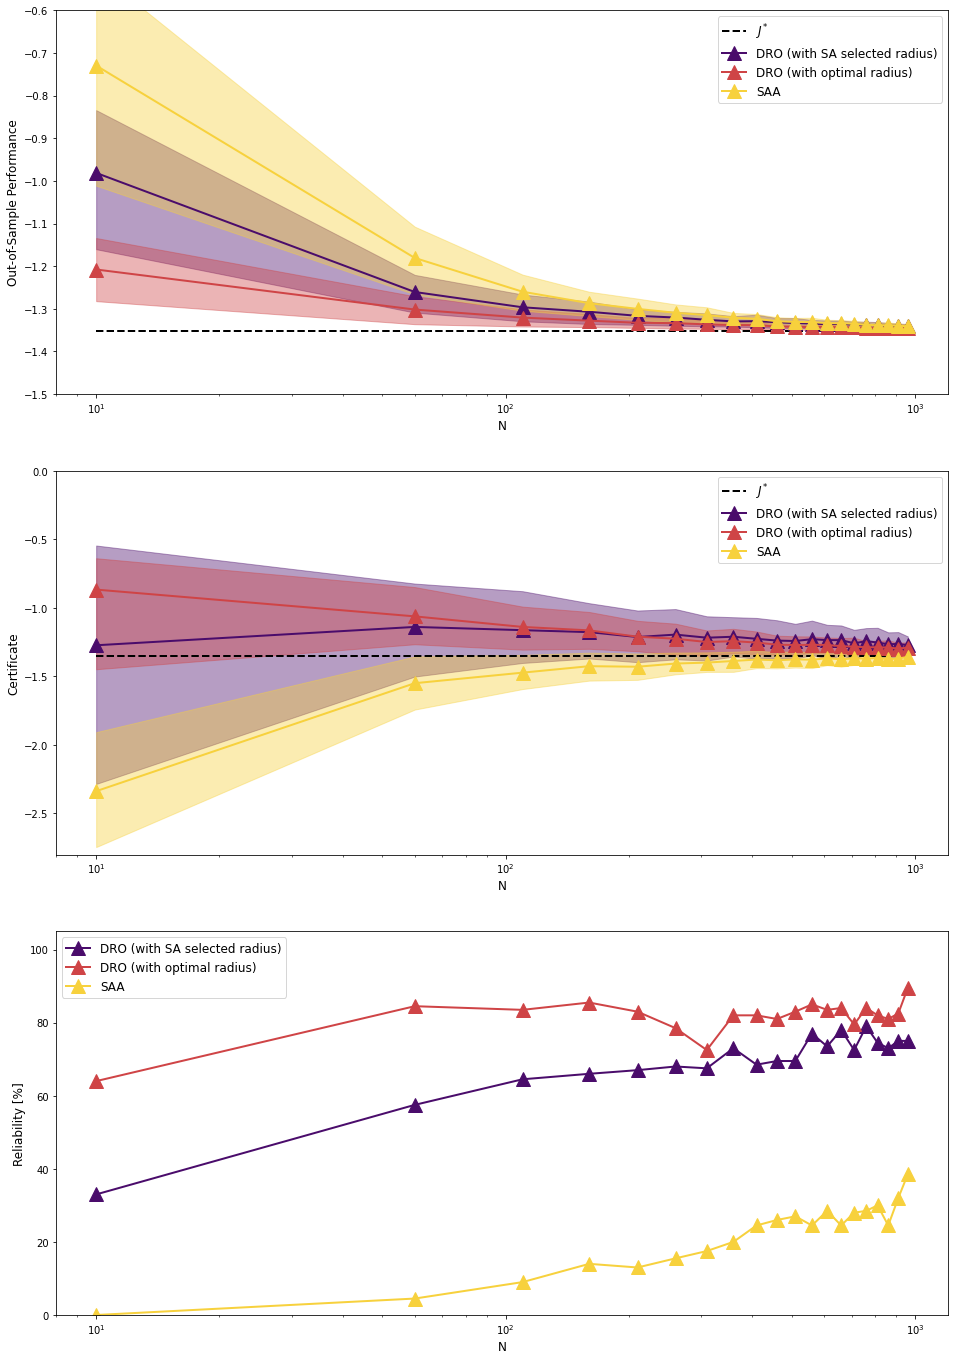

In [93]:
# Specify colors
myMap = plt.get_cmap('inferno') # Paired, inferno
colors = myMap(np.linspace(0,1,m))

# Set colors from the scale used for plotting the weights
colorDRO_SA = colors[2]
colorDRO_epsOpt = colors[5]
colorSAA = colors[8]

# Control the width of the confidence intervals
lower = 0.20
upper = 0.80

# Prepare plots
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 24))

# Plot the OoS-performance
ax[0].plot(gridN, np.repeat(JwOptSAA, len(gridN)), color='black', linewidth=2, linestyle="--", label=r'$J^{*}$')
ax[0].plot(gridN, np.mean(results_DRO_OoS_SA_Fig6, axis=0), color=colorDRO_SA, linewidth=2, marker="^", markersize=14, label="DRO (with SA selected radius)")
ax[0].fill_between(gridN, np.quantile(results_DRO_OoS_SA_Fig6, lower, axis=0), np.quantile(results_DRO_OoS_SA_Fig6, upper, axis=0), color=colorDRO_SA, alpha=0.4)
ax[0].plot(gridN, np.mean(results_DRO_OoS_epsOpt_Fig6, axis=0), color=colorDRO_epsOpt, linewidth=2, marker="^", markersize=14, label="DRO (with optimal radius)")
ax[0].fill_between(gridN, np.quantile(results_DRO_OoS_epsOpt_Fig6, lower, axis=0), np.quantile(results_DRO_OoS_epsOpt_Fig6, upper, axis=0), color=colorDRO_epsOpt, alpha=0.4)
ax[0].plot(gridN, np.mean(results_SAA_OoS_Fig6, axis=0), color=colorSAA, linewidth=2, marker="^", markersize=14, label="SAA")
ax[0].fill_between(gridN, np.quantile(results_SAA_OoS_Fig6, lower, axis=0), np.quantile(results_SAA_OoS_Fig6, upper, axis=0), color=colorSAA, alpha=0.4)
ax[0].set_xlabel(r'N', fontsize=12)
ax[0].set_ylabel(r'Out-of-Sample Performance', fontsize=12)
ax[0].legend(loc="best", facecolor="white", fontsize=12)
ax[0].set_xscale('log')
ax[0].set_ylim([-1.5,-0.6])

# Plot certificates
ax[1].plot(gridN, np.repeat(JwOptSAA, len(gridN)), color='black', linewidth=2, linestyle="--", label=r'$J^{*}$')
ax[1].plot(gridN, np.mean(results_DRO_SA_Certificate_Fig6, axis=0), color=colorDRO_SA, linewidth=2, marker="^", markersize=14, label="DRO (with SA selected radius)")
ax[1].fill_between(gridN, np.quantile(results_DRO_SA_Certificate_Fig6, lower, axis=0), np.quantile(results_DRO_SA_Certificate_Fig6, upper, axis=0), color=colorDRO_SA, alpha=0.4)
ax[1].plot(gridN, np.mean(results_DRO_epsOpt_Certificate_Fig6, axis=0), color=colorDRO_epsOpt, linewidth=2, marker="^", markersize=14, label="DRO (with optimal radius)")
ax[1].fill_between(gridN, np.quantile(results_DRO_epsOpt_Certificate_Fig6, lower, axis=0), np.quantile(results_DRO_epsOpt_Certificate_Fig6, upper, axis=0), color=colorDRO_epsOpt, alpha=0.4)
ax[1].plot(gridN, np.mean(results_SAA_Certificate_Fig6, axis=0), color=colorSAA, linewidth=2, marker="^", markersize=14, label="SAA")
ax[1].fill_between(gridN, np.quantile(results_SAA_Certificate_Fig6, lower, axis=0), np.quantile(results_SAA_Certificate_Fig6, upper, axis=0), color=colorSAA, alpha=0.4)
ax[1].set_xlabel(r'N', fontsize=12)
ax[1].set_ylabel(r'Certificate', fontsize=12)
ax[1].legend(loc="best", facecolor="white", fontsize=12)
ax[1].set_xscale('log')
ax[1].set_ylim([-2.8,0])

# Plot reliability
ax[2].plot(gridN, Reliability_DRO_SA, color=colorDRO_SA, linewidth=2, marker="^", markersize=14, label="DRO (with SA selected radius)")
ax[2].plot(gridN, Reliability_DRO_epsOpt, color=colorDRO_epsOpt, linewidth=2, marker="^", markersize=14, label="DRO (with optimal radius)")
ax[2].plot(gridN, Reliability_SAA, color=colorSAA, linewidth=2, marker="^", markersize=14, label="SAA")
ax[2].set_xlabel(r'N', fontsize=12)
ax[2].set_ylabel(r'Reliability [%]', fontsize=12)
ax[2].legend(loc="best", facecolor="white", fontsize=12)
ax[2].set_xscale('log')
ax[2].set_ylim([0,105])

# Save figure
plt.savefig('./ReplicationResults/Fig6_{}_{}.png'.format(nSim, gridN), dpi=200)

# Show figure
plt.show()